# Reading 1D ecRad Output File

v1 2023-05-29

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
3. pysolar : 0.10
4. matplotlib : 3.6.2
5. scipy : 1.10.0

In [8]:
import os

import numpy as np
import xarray as xr
import pandas as pd
import scipy
from scipy import signal
from scipy import interpolate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# Setting Font in Figures
#matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
#matplotlib.rcParams['font.family']     = 'sans-serif'

%matplotlib notebook

## Reading ecRad output data

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
ecrad_out = xr.open_dataset(data_path+'output_1D_bottom_240_test_v1.nc')

### Cloud Heating Rate (CRH) calculation:

In [34]:
## Heating rates [K day-1]:
H_lw = []
H_sw = []
H    = []

# Heat capacity [J kg-1 K-1]:
cp = 1.08*10**(3)
# Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
# Gravity [m s-2]:
g = 9.8

pres = ecrad_out.pressure_hl.values # Pressure [Pa]

# Net Fluxes [W m-2]
lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values - ecrad_out.flux_up_lw.values
lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values - ecrad_out.flux_up_lw_clear.values
sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values - ecrad_out.flux_up_sw.values
sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values - ecrad_out.flux_up_sw_clear.values

# Cloud Radiative Effect [W m-2]
lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

# rad = pd.DataFrame({'pressure_hPa':pres*0.01,'lw_cre_Wm2':lw_cre,'sw_cre_Wm2':sw_cre})
# rad = rad.set_index('pressure_hPa')

H_lw = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day-1
H_sw = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day-1
H    = H_lw + H_sw

#### Plotting 1-column CRH Profile

Temperature

In [11]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')
temp = tropical_profile['temperature (K)'].iloc[::-1]

/tmp/ipykernel_81311/224132646.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [64]:
melting_layer = temp.iloc[(temp - 273.15).abs().argmin()]
tropopause    = temp.min()

<IPython.core.display.Javascript object>


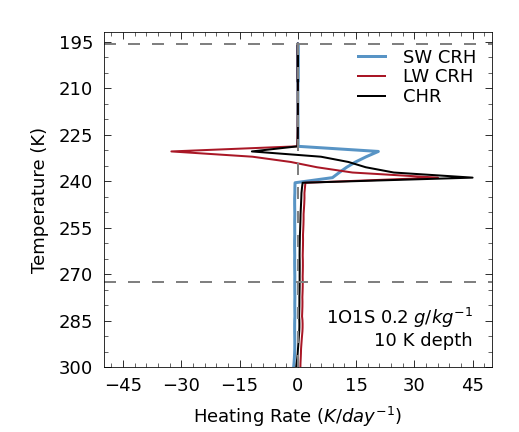

In [69]:
fontsize  = 18
heigth    = 6 # inches
length    = heigth*1.2 # inches
my_colors = [(88/255,148/255,197/255),(169/255,23/255,38/255),
             (229/255,179/255,69/255),(131/255,170/255,69/255),
             (116/255,24/255,123/255),(202/255,91/255,46/255),
             (107/255,188/255,233/255),'grey']
# Old blue (29/255,91/255,162/255)

f, ax = plt.subplots(figsize = (length,heigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.2, right = 0.95,
                    hspace = .4, wspace = .5)

h1 = ax.plot(H_sw[0], temp, linestyle = 'solid', linewidth=3,
             color = my_colors[0], alpha = 1)
h2 = ax.plot(H_lw[0], temp, linestyle = 'solid', linewidth=2,
             color = my_colors[1], alpha = 1)
h3 = ax.plot(H[0], temp, linestyle = 'solid', linewidth=2,
             color ='black', alpha = 1)
h4 = ax.axvline(x = 0, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
h5 = ax.axhline(y = melting_layer, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
h6 = ax.axhline(y = tropopause, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)


# X Axis:
ax.set_xlabel(r'Heating Rate $(K/day^{-1})$', fontsize = fontsize,
              color = 'black',labelpad = 10)
major_ticks_x = np.arange(-60,60,15)
minor_ticks_x = np.arange(-60,60,3)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(-50,50)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
    
# Y Axis:
ax.set_ylabel(r'Temperature (K)', fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(0, 450, 15)
minor_ticks_y = np.arange(0, 450, 5)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(300,192)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor', color = 'black',
               size = 4, direction = 'in', right = True)
        
# Legend:
handles = h1 + h2 + h3
labels  = ['SW CRH','LW CRH','CHR']    
legend  = plt.legend(handles, labels, loc = 'upper right',#bbox_to_anchor=(.675, 1.075),#
                     ncol = 1, handlelength = 1.5, handletextpad = 1,
                     labelspacing = .1, columnspacing = 2, numpoints = 1,
                     frameon = False, prop = {'size':fontsize})

# Additional Texts:
# ax.set_title('BOD Degradation over time',
#              fontsize=fontsize,
#              fontweight='bold',
#              color='black')
ax.text(0.95, 0.05, r'1O1S 0.2 $g/kg^{-1}$'+'\n'+'10 K depth',
        ha = 'right', va = 'bottom', transform = ax.transAxes,
        fontsize = fontsize, color = 'black')

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig(out_dir+'1D_240_bottom_1O1S0A0r_v1.png', dpi = 500)